In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline
%config InlineBackend.figure_format='retina'

S&P 500


In [ ]:
import requests
import pandas as pd

# Tiingo API Key
API_KEY = "4abfd73b7ac25887d7eb768fb08f8cb55cb5ea4a"

# Keep the variable names the same
headers = {
    "Content-Type": "application/json"
}

# Date range
start_date = "2024-04-17"
end_date = "2025-05-21"

# Tiingo API URL for SPY daily prices
alpaca_url = f"https://api.tiingo.com/tiingo/daily/spy/prices"
params = {
    "startDate": start_date,
    "endDate": end_date,
    "token": API_KEY
}

response = requests.get(alpaca_url, headers=headers, params=params)

if response.status_code == 200:
    spy_data = response.json()
    spy_df = pd.DataFrame(spy_data)
    spy_df['date'] = pd.to_datetime(spy_df['date'])
    spy_df.set_index('date', inplace=True)
    spy_df.rename(columns={"close": "Close"}, inplace=True)
else:
    print("Failed to fetch SPY data:", response.status_code, response.text)

FRED Data


In [ ]:
# FRED API key
FRED_API_KEY = "d6731686797bedfdd8a3a0101f3a204c"

# FRED endpoint for Reverse Repo daily totals
fred_url = (
    "https://api.stlouisfed.org/fred/series/observations"
    "?series_id=RRPONTSYD"
    f"&api_key={FRED_API_KEY}"
    "&file_type=json"
    f"&observation_start={start_date}&observation_end={end_date}"
)

response = requests.get(fred_url)

if response.status_code == 200:
    obs = response.json()["observations"]
    df = pd.DataFrame(obs)
    df['operationDt'] = pd.to_datetime(df['date'])
    df['totalAmtAccepted'] = pd.to_numeric(df['value'], errors='coerce')
    df = df[['operationDt', 'totalAmtAccepted']].dropna()

    # Remove outliers using MAD (optional)
    window_size = 5
    rolling_median = df['totalAmtAccepted'].rolling(window=window_size).median()
    MAD = (df['totalAmtAccepted'] - rolling_median).abs().rolling(window=window_size).median()
    is_outlier = (df['totalAmtAccepted'] - rolling_median).abs() > 1.5 * MAD
    df = df[~is_outlier]
else:
    print("Failed to fetch FRED Reverse Repo data:", response.status_code)

In [ ]:
# Convert both to date-only to ensure perfect alignment
df['operationDt'] = df['operationDt'].dt.date
spy_df.index = spy_df.index.date

# Rebuild proper index from date-only values
spy_df = pd.DataFrame(spy_df.values, index=pd.to_datetime(spy_df.index), columns=spy_df.columns)
df['operationDt'] = pd.to_datetime(df['operationDt'])

# Merge the dataframes
merged_df = df.merge(spy_df, left_on='operationDt', right_index=True)

# Drop any remaining NaNs
clean_df = merged_df.dropna(subset=['totalAmtAccepted', 'Close'])

# Check and print correlation
correlation = clean_df['totalAmtAccepted'].corr(clean_df['Close'])
print(f"Cleaned correlation: {correlation:.4f}")

Cleaned correlation: -0.6408


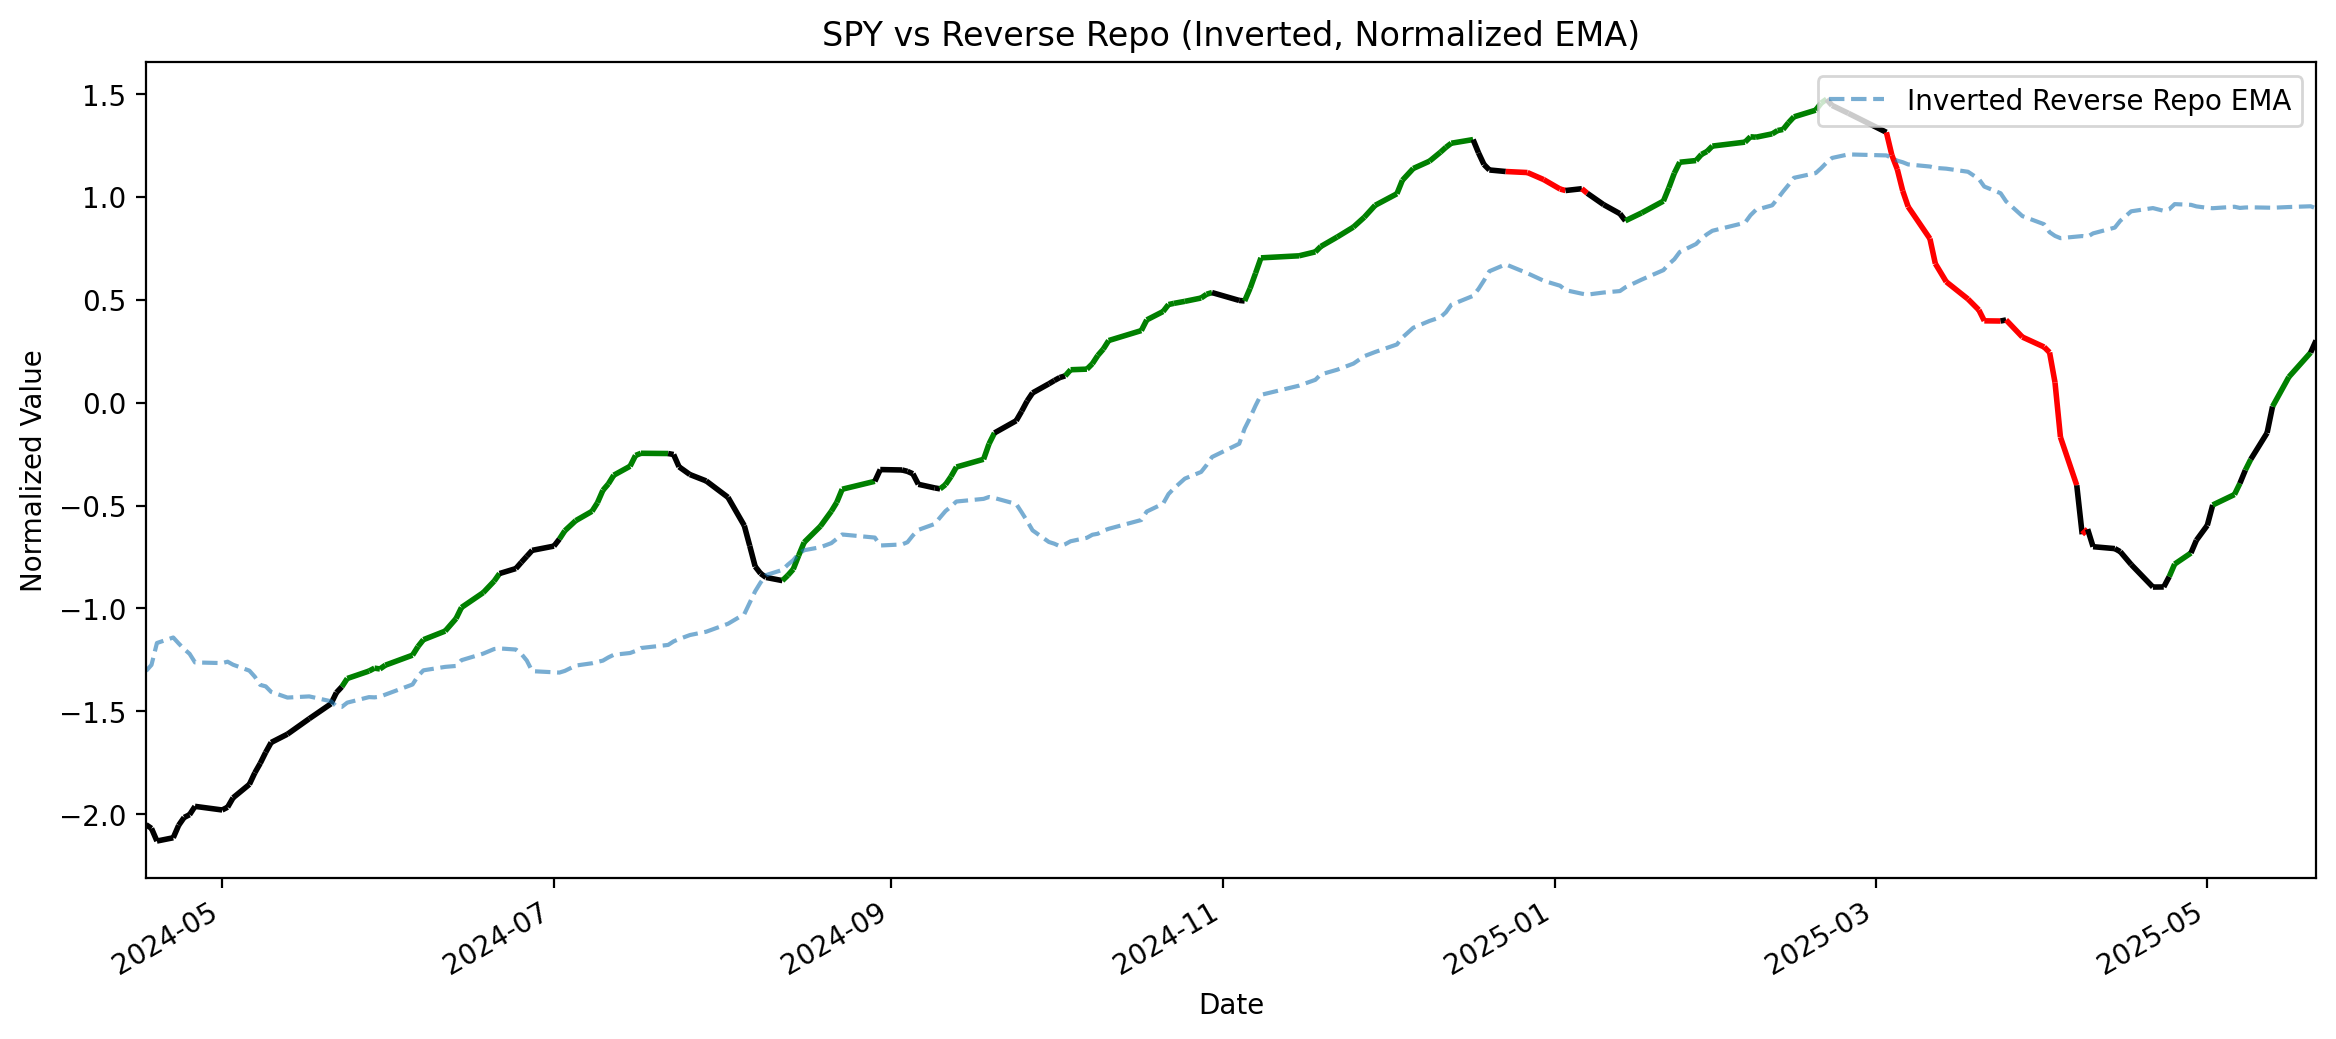

In [ ]:
import matplotlib.dates as mdates

# Clean data for plotting
plot_df = merged_df.dropna(subset=['operationDt', 'totalAmtAccepted', 'Close'])

# Normalize values
repo_norm = (plot_df['totalAmtAccepted'] - plot_df['totalAmtAccepted'].mean()) / plot_df['totalAmtAccepted'].std()
spy_norm = (plot_df['Close'] - plot_df['Close'].mean()) / plot_df['Close'].std()

# Invert repo
repo_norm *= -1

# Smooth using EMA
repo_ema = repo_norm.ewm(span=30).mean().to_numpy()
spy_ema = spy_norm.ewm(span=14).mean().to_numpy()

# Gradients
repo_grad = np.gradient(repo_ema)
spy_grad = np.gradient(spy_ema)

# Colors for LineCollection
colors = np.where((spy_grad > 0) & (repo_grad > 0), 'green',
                  np.where((spy_grad < 0) & (repo_grad < 0), 'red', 'black'))

# Convert dates to matplotlib float format
dates = mdates.date2num(plot_df['operationDt'].to_numpy())

# Build segments
points = np.array([dates, spy_ema]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
lc = LineCollection(segments, colors=colors[:-1], linewidths=2)
ax.add_collection(lc)

# Plot inverted repo EMA
ax.plot(plot_df['operationDt'], repo_ema, label="Inverted Reverse Repo EMA", linestyle='--', alpha=0.6)

# Formatting
ax.set_title("SPY vs Reverse Repo (Inverted, Normalized EMA)")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Value")
ax.legend()
ax.set_xlim(plot_df['operationDt'].min(), plot_df['operationDt'].max())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.show()

In [ ]:
# Use previous EMA + gradient calculations
plot_df = merged_df.dropna(subset=['operationDt', 'totalAmtAccepted', 'Close'])

# Normalize
repo_norm = (plot_df['totalAmtAccepted'] - plot_df['totalAmtAccepted'].mean()) / plot_df['totalAmtAccepted'].std()
spy_norm = (plot_df['Close'] - plot_df['Close'].mean()) / plot_df['Close'].std()
repo_norm *= -1

# EMAs
repo_ema = repo_norm.ewm(span=30).mean()
spy_ema = spy_norm.ewm(span=14).mean()

# Gradients
repo_grad = np.gradient(repo_ema)
spy_grad = np.gradient(spy_ema)

# Binary signal: BUY when both gradients > 0
signal = (spy_grad > 0) & (repo_grad > 0)

# Get SPY returns
plot_df['return'] = plot_df['Close'].pct_change()
plot_df['signal'] = signal

# Compare returns on signal days vs non-signal days
signal_returns = plot_df.loc[plot_df['signal'], 'return']
non_signal_returns = plot_df.loc[~plot_df['signal'], 'return']

print(f"Avg daily return on signal days: {signal_returns.mean():.4%}")
print(f"Avg daily return on other days: {non_signal_returns.mean():.4%}")

Avg daily return on signal days: 0.3423%
Avg daily return on other days: -0.1623%


<Axes: title={'center': 'Cumulative Returns: Signal vs Buy & Hold'}>

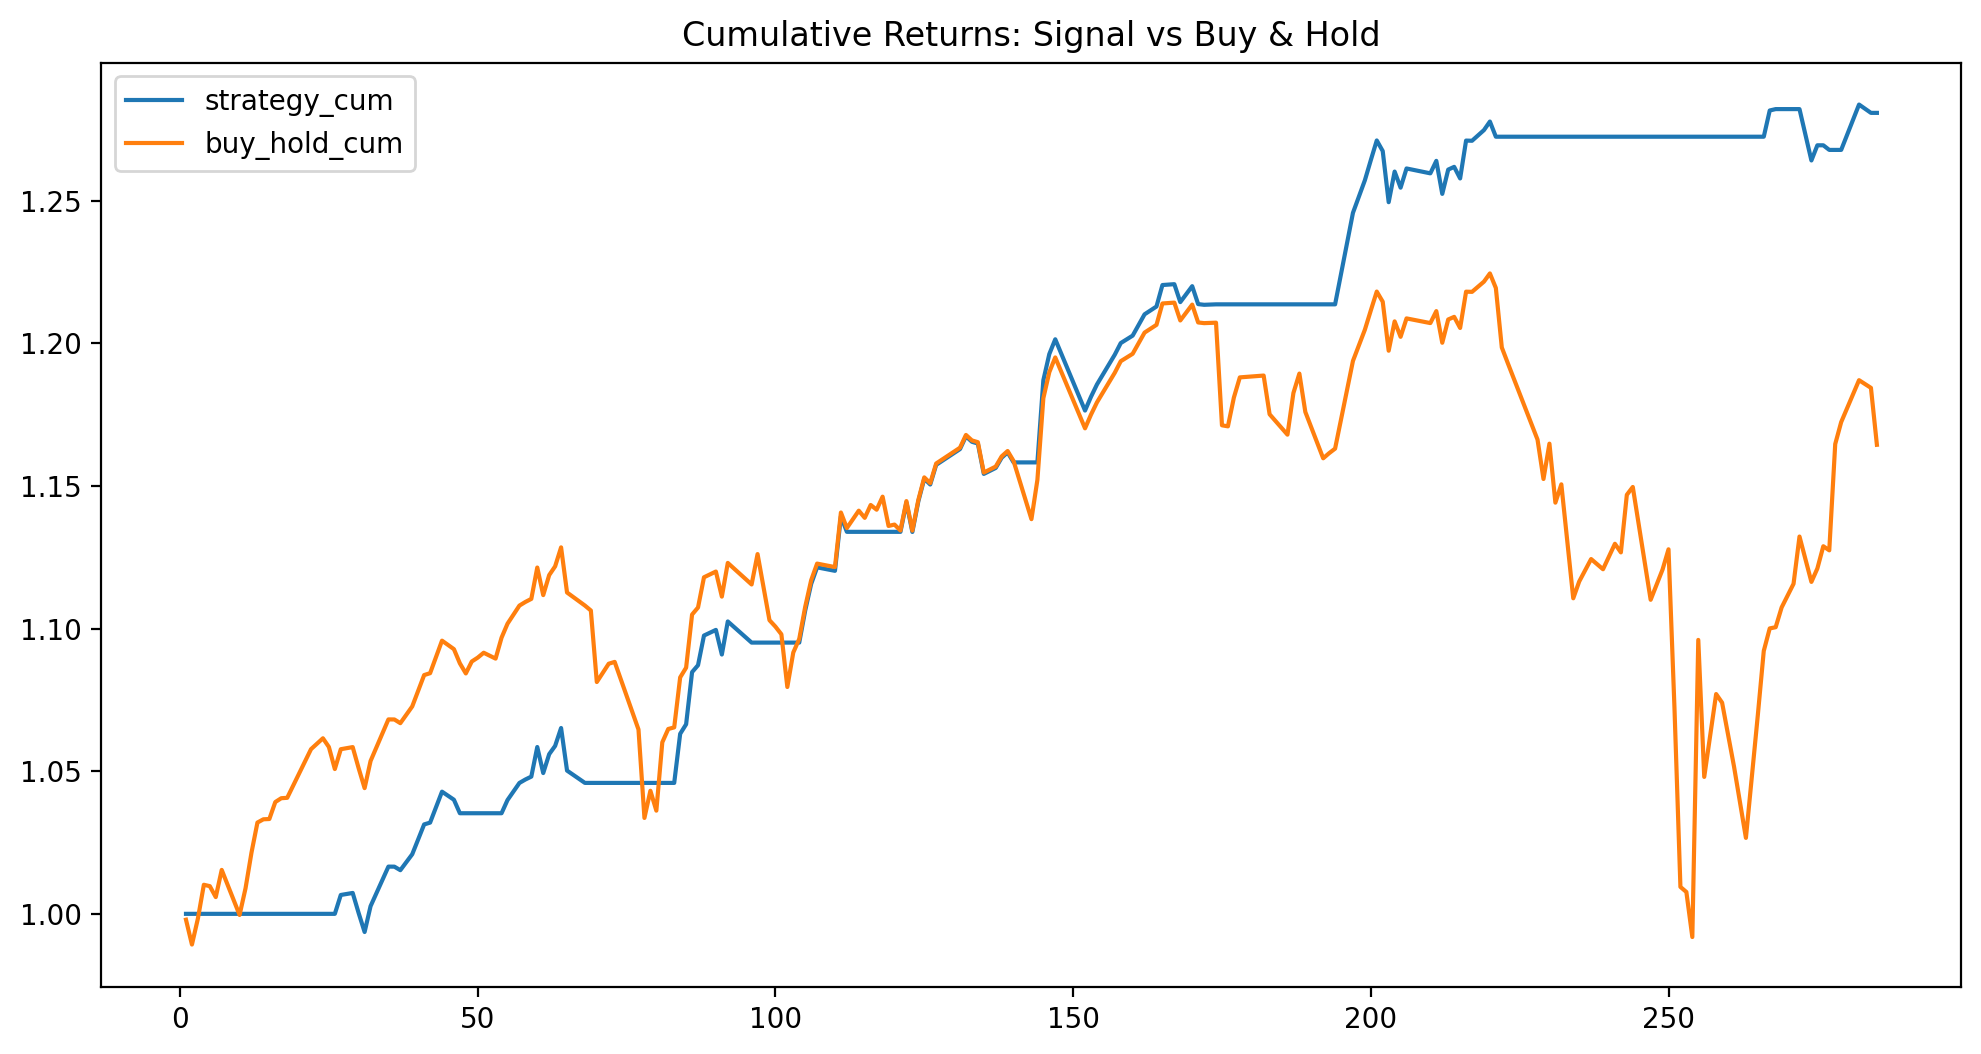

In [ ]:
# Daily return from SPY
plot_df['return'] = plot_df['Close'].pct_change()

# Use previous day's signal to simulate real execution
plot_df['signal'] = signal
plot_df['signal_shifted'] = plot_df['signal'].shift(1)

# Strategy return = today's return * yesterday's signal
plot_df['strategy_return'] = plot_df['return'] * plot_df['signal_shifted']
plot_df['buy_hold'] = plot_df['return']

plot_df['strategy_cum'] = (1 + plot_df['strategy_return']).cumprod()
plot_df['buy_hold_cum'] = (1 + plot_df['buy_hold']).cumprod()

plot_df[['strategy_cum', 'buy_hold_cum']].plot(figsize=(12, 6), title="Cumulative Returns: Signal vs Buy & Hold")

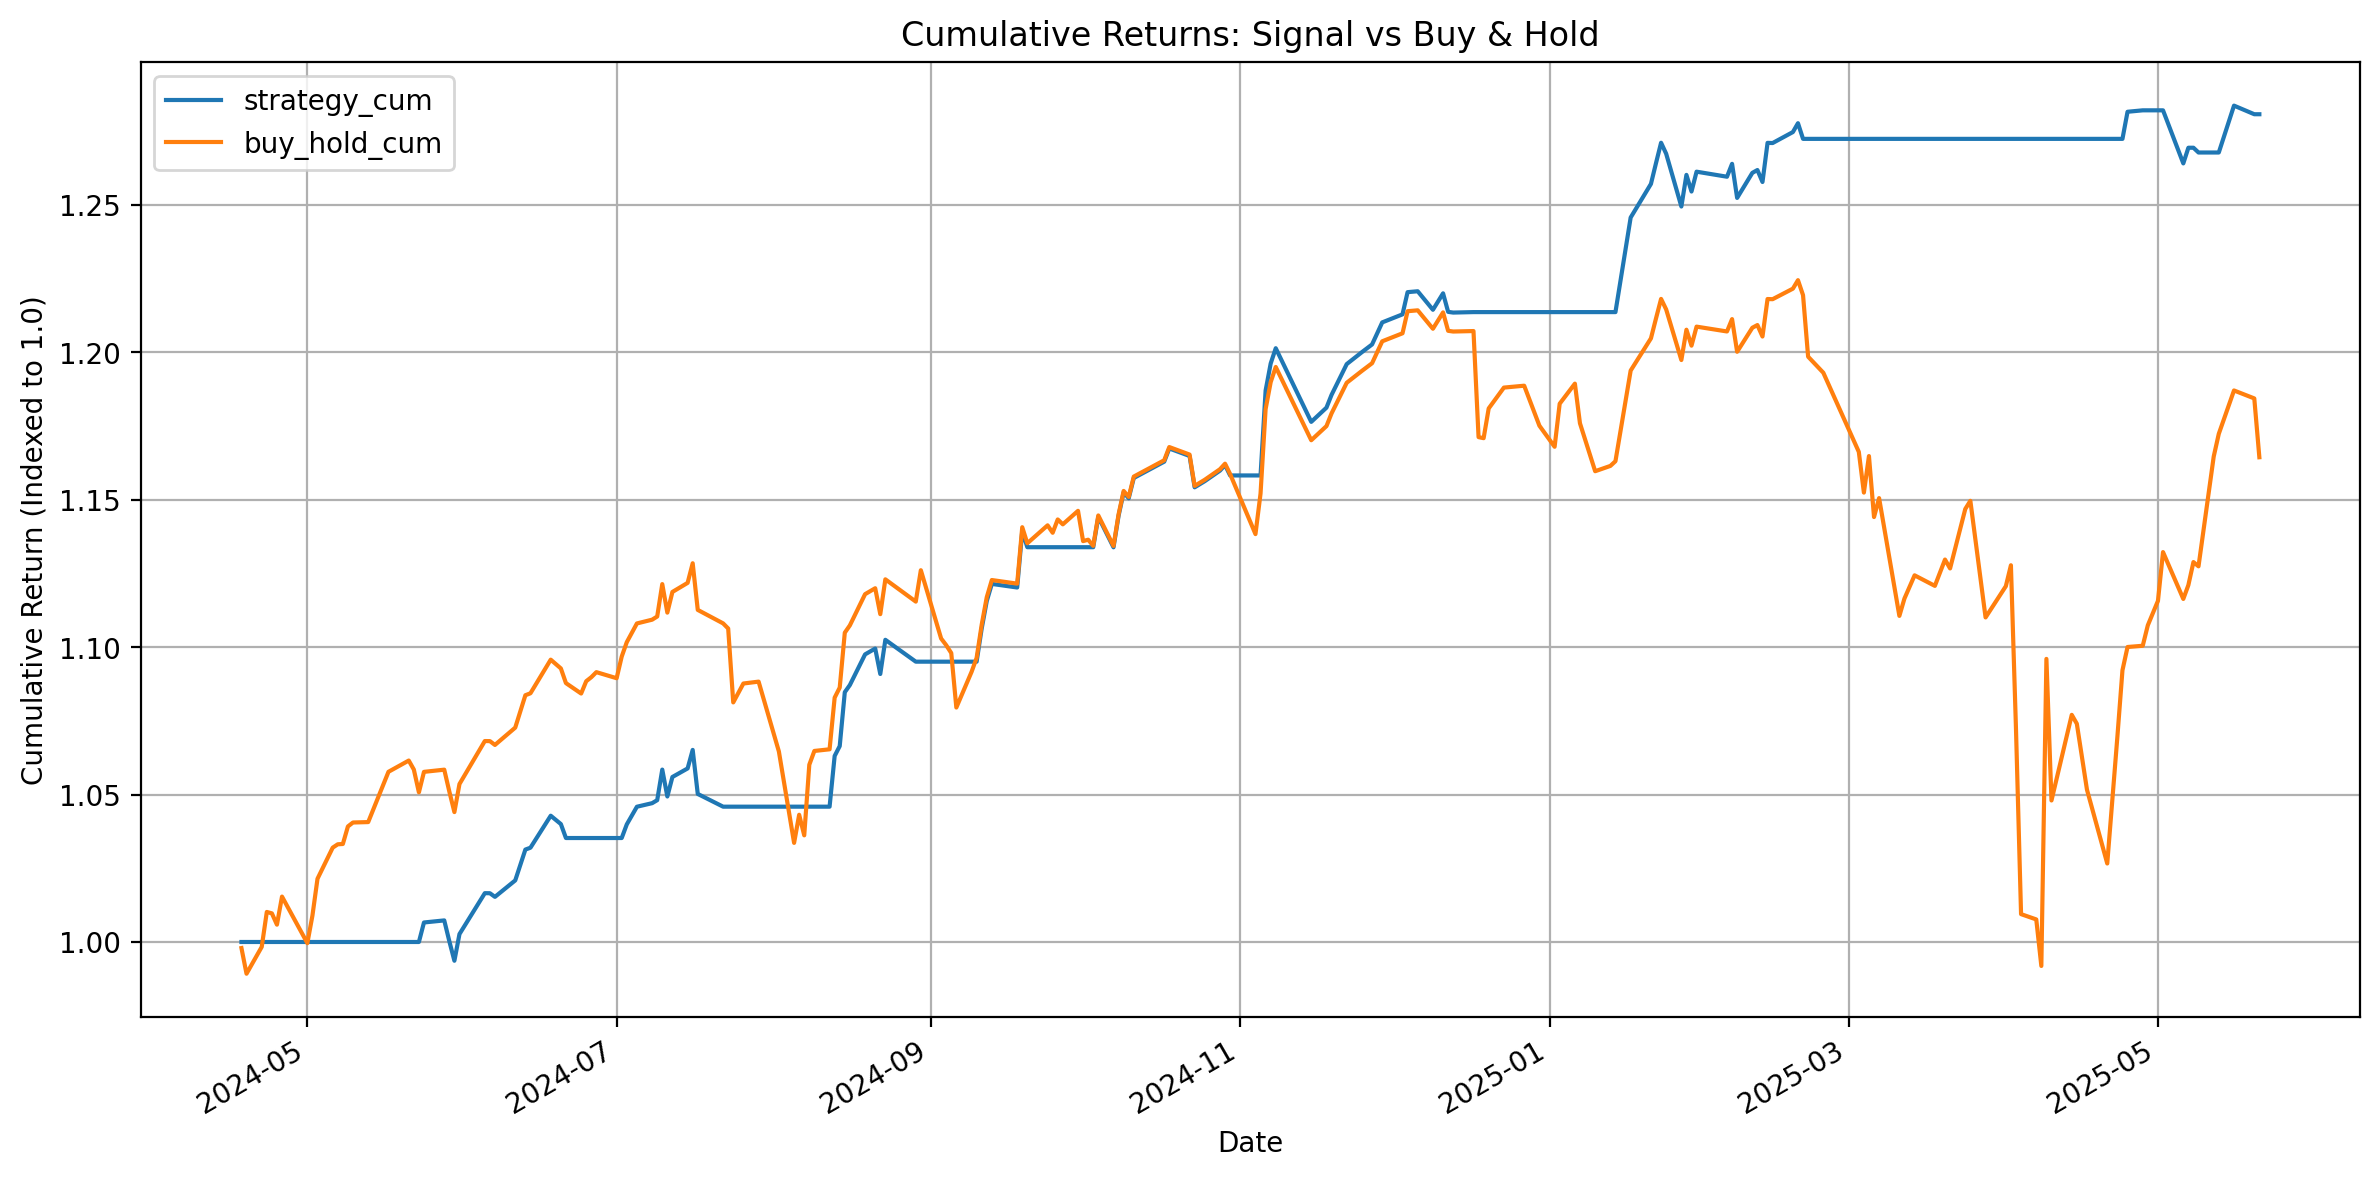

In [ ]:
# Ensure 'operationDt' is the datetime column
plot_df = plot_df.set_index('operationDt')

# Plot with actual dates on x-axis
plot_df[['strategy_cum', 'buy_hold_cum']].plot(figsize=(12, 6), title="Cumulative Returns: Signal vs Buy & Hold")

# Add labels
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Indexed to 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score

# Basic metrics
print(f"Win rate: { (signal_returns > 0).mean():.2%}" )
print(f"Volatility (signal): {signal_returns.std():.2%}")
print(f"Sharpe (signal): {signal_returns.mean() / signal_returns.std():.2f}")

Win rate: 72.00%
Volatility (signal): 0.79%
Sharpe (signal): 0.44


<Axes: title={'center': 'Strategy Drawdown'}, xlabel='operationDt'>

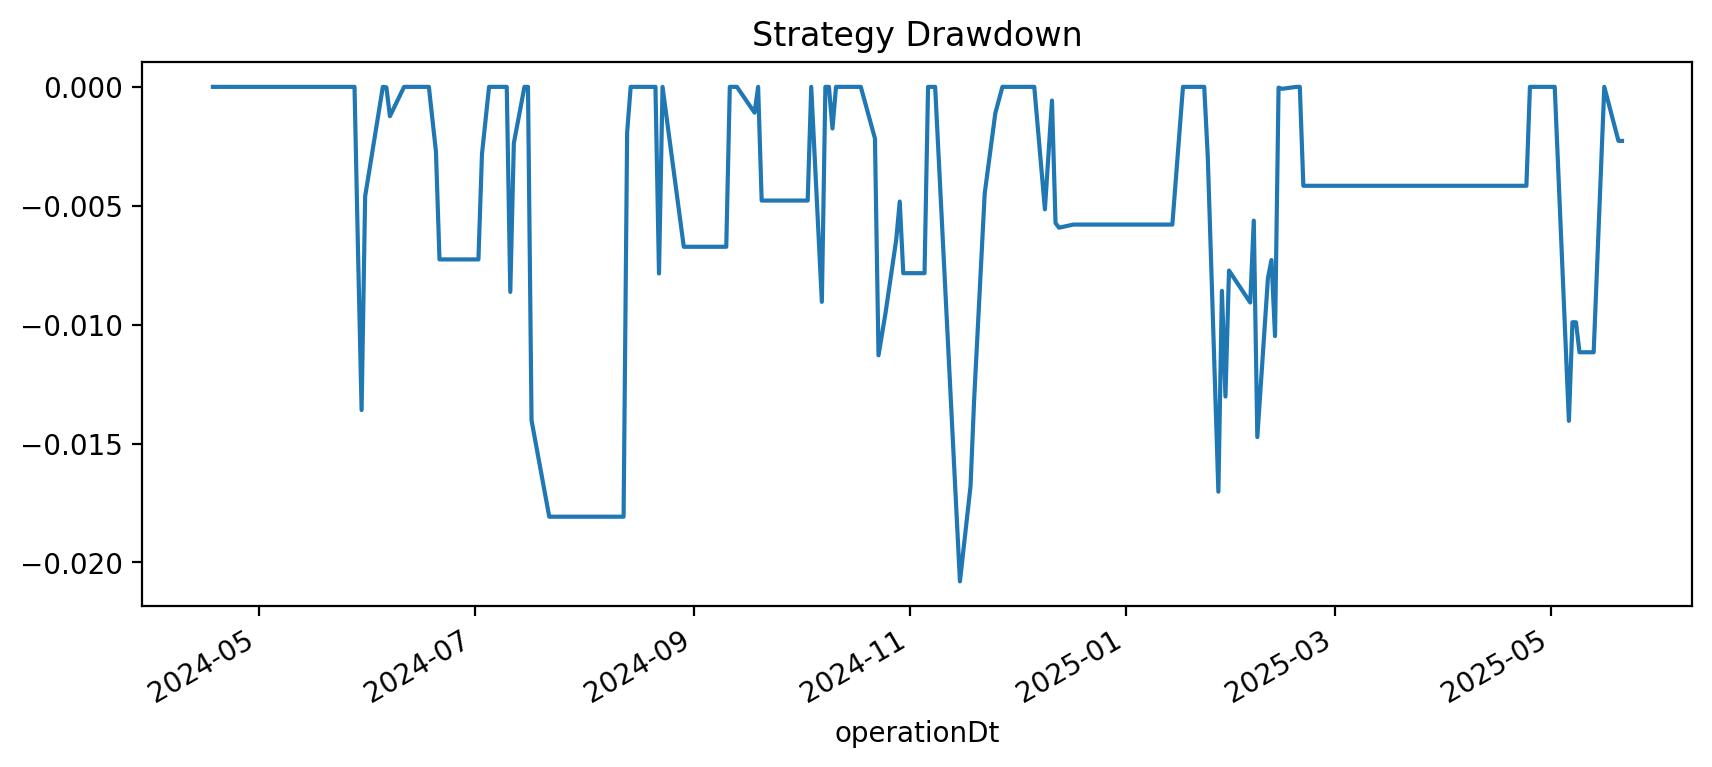

In [ ]:
running_max = plot_df['strategy_cum'].cummax()
drawdown = (plot_df['strategy_cum'] - running_max) / running_max

drawdown.plot(title='Strategy Drawdown', figsize=(10, 4))

In [ ]:
print(f"Signal exposure: {plot_df['signal'].mean():.2%} of days")

Signal exposure: 48.78% of days


In [ ]:
# Convert index to a readable date string
plot_df['Date'] = plot_df.index.strftime('%m/%d')

# Label each row as BUY or SELL
plot_df['Signal_Label'] = np.where(plot_df['signal'], 'BUY', 'SELL')

# Mark only the rows where the signal changed from the previous day
signal_changes = plot_df[plot_df['Signal_Label'] != plot_df['Signal_Label'].shift(1)]

# Show the last 5 signal changes
print("Recent signal changes:\n")
for _, row in signal_changes.tail(5).iterrows():
    print(f"{row['Date']}: {row['Signal_Label']}")

Recent signal changes:

05/07: SELL
05/08: BUY
05/09: SELL
05/13: BUY
05/20: SELL


In [ ]:
# Ensure datetime index
plot_df.index = pd.to_datetime(plot_df.index)

# Generate raw signal label
plot_df['Signal_Label'] = np.where(plot_df['signal'], 'BUY', 'SELL')

# Track changes only
plot_df['Signal_Change'] = plot_df['Signal_Label'] != plot_df['Signal_Label'].shift(1)

# Create a new column to show HOLDs after change
plot_df['Signal_Action'] = np.where(plot_df['Signal_Change'], plot_df['Signal_Label'], 'HOLD')

# Get the last true signal change (BUY or SELL)
last_change = plot_df[plot_df['Signal_Action'] != 'HOLD'].iloc[-1]

print("Last Signal Change:")
print(f"{last_change.name.strftime('%Y-%m-%d')} → {last_change['Signal_Action']}\n")

# Show last 5 days of status
recent_status = plot_df[['Signal_Action']].tail(5)
print("Signal Status (Last 5 Days):\n")
for idx, row in recent_status.iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}: {row['Signal_Action']}")

Last Signal Change:
2025-05-20 → SELL

Signal Status (Last 5 Days):

2025-05-12: HOLD
2025-05-13: BUY
2025-05-16: HOLD
2025-05-20: SELL
2025-05-21: HOLD


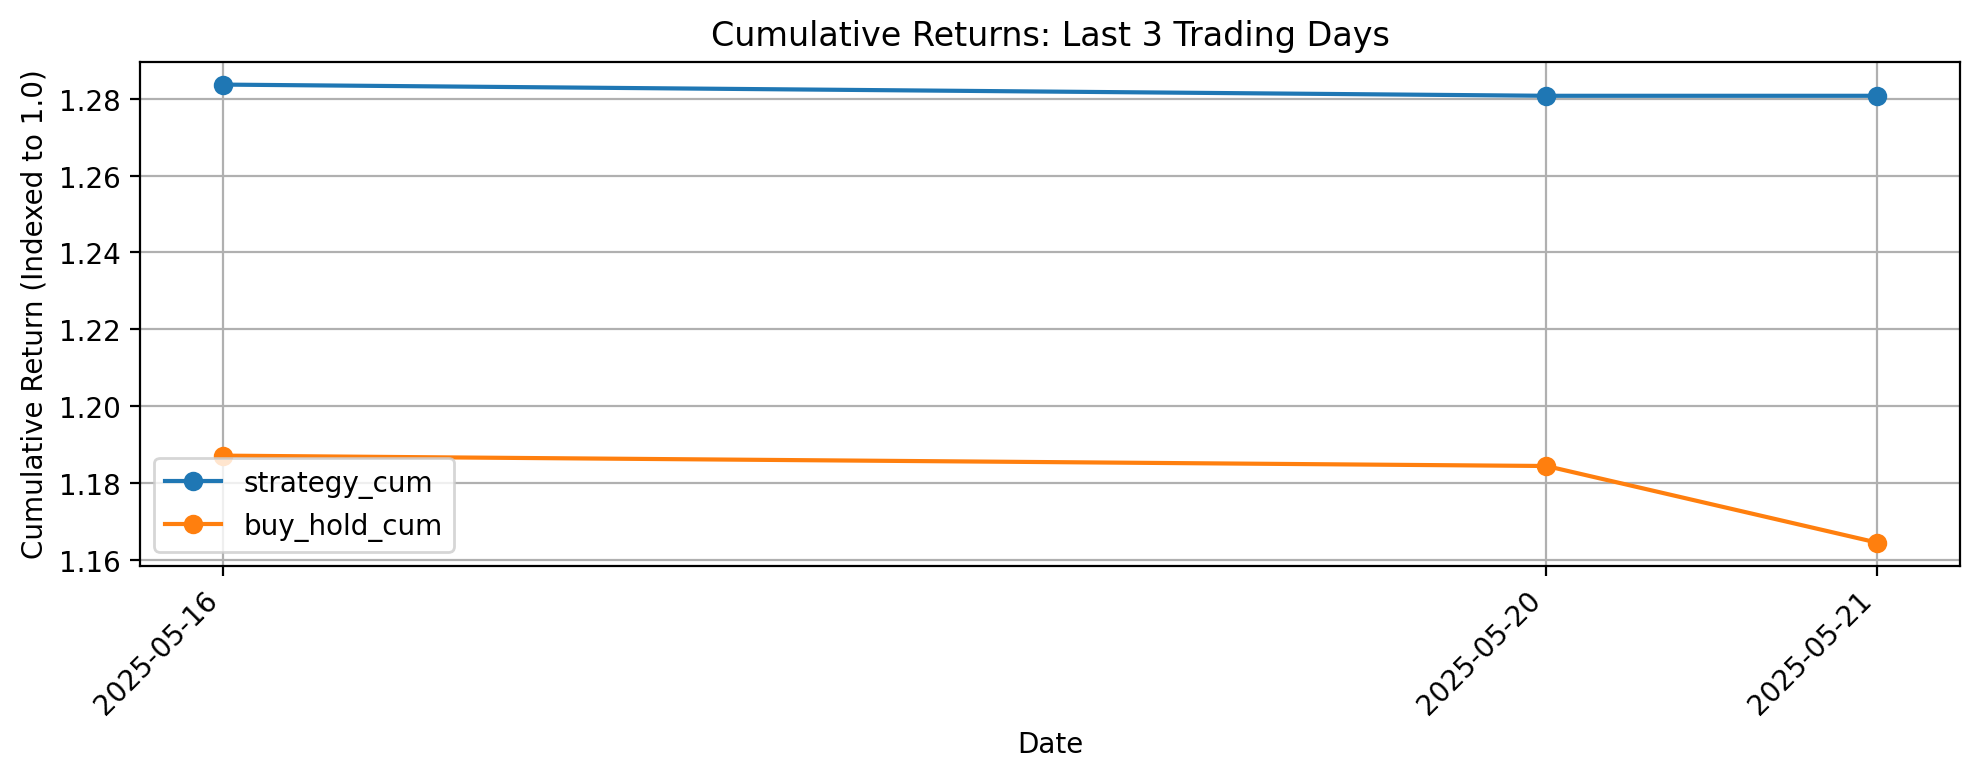

In [ ]:
import matplotlib.pyplot as plt

#Grabs the last 3 rows
last_3 = plot_df.tail(3)

#Plots strategy vs buy-and-hold cumulative returns
fig, ax = plt.subplots(figsize=(10, 4))
last_3[['strategy_cum', 'buy_hold_cum']].plot(
    ax=ax,
    marker='o',
    title='Cumulative Returns: Last 3 Trading Days'
)

#Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return (Indexed to 1.0)")
ax.set_xticks(last_3.index)
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in last_3.index], rotation=45)
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plot_df['pre_shift_strategy_return'] = plot_df['return'] * plot_df['signal']
print("Pre-shift Sharpe:", plot_df['pre_shift_strategy_return'].mean() / plot_df['pre_shift_strategy_return'].std())
print("Post-shift Sharpe:", plot_df['strategy_return'].mean() / plot_df['strategy_return'].std())

Pre-shift Sharpe: 0.2915860180852562
Post-shift Sharpe: 0.22381444439204054


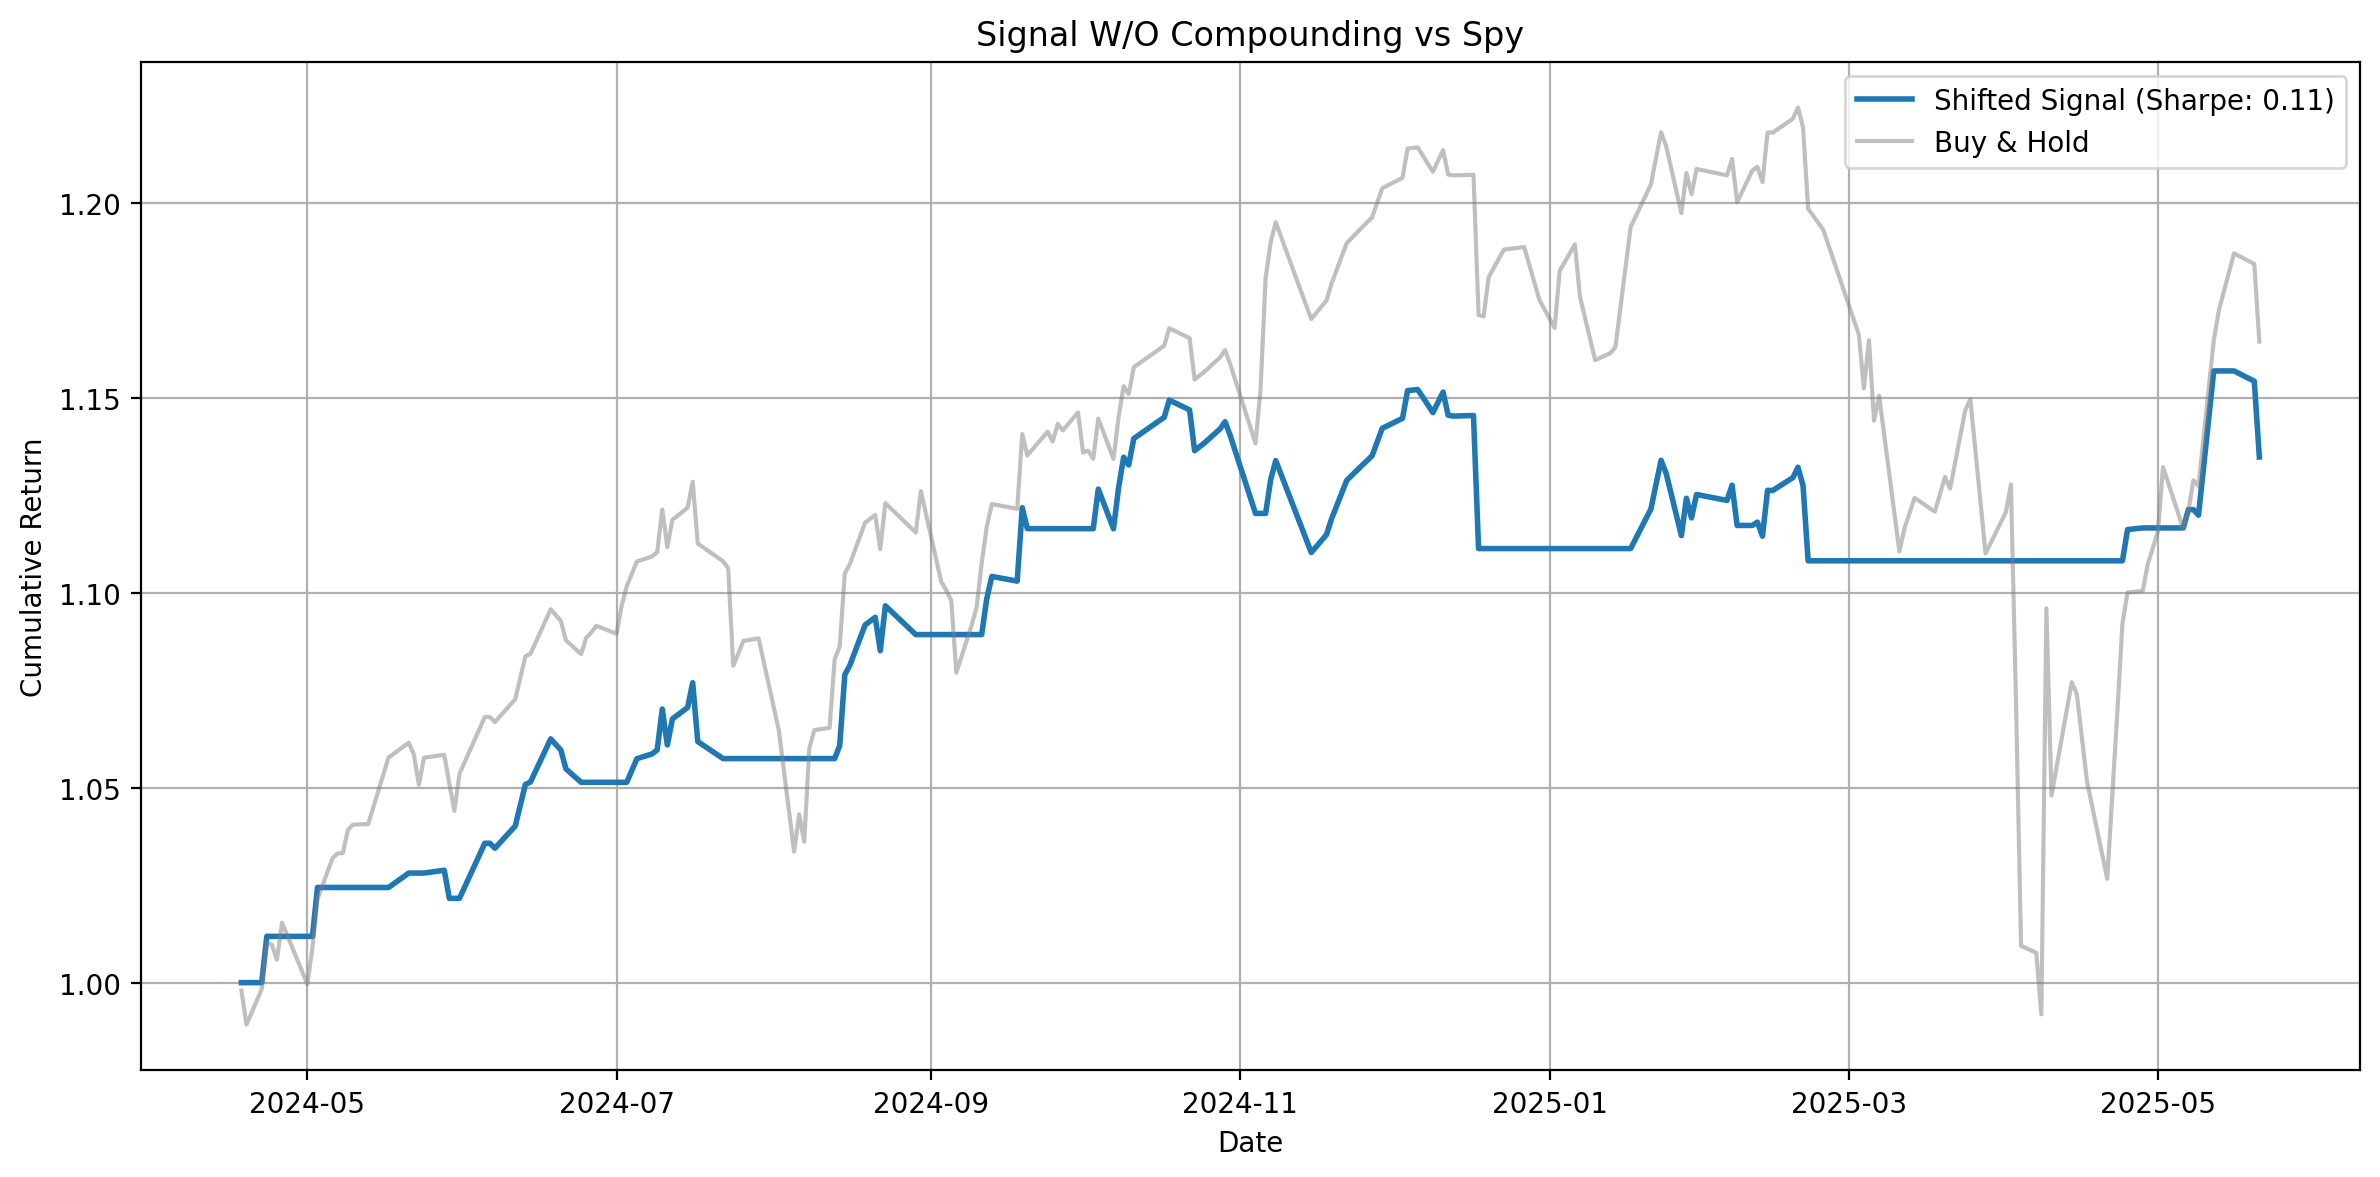

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_gradient(series):
    # Causal (safe) gradient using diff
    return series.diff()

def apply_strategy(plot_df, spy_span=14, repo_span=30, threshold=0.0, shifted=True):
    # Normalize
    repo_norm = (plot_df['totalAmtAccepted'] - plot_df['totalAmtAccepted'].mean()) / plot_df['totalAmtAccepted'].std()
    spy_norm = (plot_df['Close'] - plot_df['Close'].mean()) / plot_df['Close'].std()
    repo_norm *= -1  # Invert liquidity

    # Smooth with EMA
    spy_ema = spy_norm.ewm(span=spy_span).mean()
    repo_ema = repo_norm.ewm(span=repo_span).mean()

    # Gradients
    spy_grad = compute_gradient(spy_ema)
    repo_grad = compute_gradient(repo_ema)

    # Signal: both gradients must be above threshold
    signal = (spy_grad > threshold) & (repo_grad > threshold)

    # Use signal from previous day if shifted (realistic)
    signal_to_use = signal.shift(1) if shifted else signal

    # Daily returns
    plot_df['return'] = plot_df['Close'].pct_change()
    plot_df['strategy_return'] = plot_df['return'] * signal_to_use

    # Cumulative return
    plot_df['strategy_cum'] = (1 + plot_df['strategy_return']).cumprod()
    plot_df['buy_hold_cum'] = (1 + plot_df['return']).cumprod()

    # Sharpe
    sharpe = plot_df['strategy_return'].mean() / plot_df['strategy_return'].std()

    return plot_df[['strategy_cum', 'buy_hold_cum']], sharpe, signal_to_use

# === RUN THE TEST ===

# Make a copy so you don't overwrite your original data
df_copy = plot_df.copy()

# Run with shift (realistic)
result_shifted, sharpe_shifted, _ = apply_strategy(df_copy.copy(), shifted=True)

# Run without shift (leaked)
result_leaked, sharpe_leaked, _ = apply_strategy(df_copy.copy(), shifted=False)

#Plot
plt.figure(figsize=(12, 6))
#plt.plot(result_leaked.index, result_leaked['strategy_cum'], label=f"Leaked Signal (Sharpe: {sharpe_leaked:.2f})", linestyle='--', alpha=0.6)
plt.plot(result_shifted.index, result_shifted['strategy_cum'], label=f"Shifted Signal (Sharpe: {sharpe_shifted:.2f})", linewidth=2)
plt.plot(result_shifted.index, result_shifted['buy_hold_cum'], label="Buy & Hold", color='gray', alpha=0.5)

plt.title("Signal W/O Compounding vs Spy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the performance metric function
def compute_performance_metrics(returns, label=""):
    returns = returns.dropna()
    total_return = (1 + returns).prod() - 1
    sharpe = returns.mean() / returns.std()
    max_dd = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax()) - 1
    win_rate = (returns > 0).mean()

    print(f"\n {label} Strategy Performance")
    print(f"-----------------------------")
    print(f"Total Return      : {total_return:.2%}")
    print(f"Sharpe Ratio      : {sharpe:.2f}")
    print(f"Max Drawdown      : {max_dd.min():.2%}")
    print(f"Win Rate          : {win_rate:.2%}")

    return {
        "total_return": total_return,
        "sharpe": sharpe,
        "max_drawdown": max_dd.min(),
        "win_rate": win_rate
    }

# Calculate realistic (shifted) strategy returns
plot_df['strategy_return'] = plot_df['return'] * plot_df['signal_shifted']

# Calculate leaked (unrealistic) strategy returns
plot_df['leaked_return'] = plot_df['return'] * plot_df['signal']

# Run performance comparison
compute_performance_metrics(plot_df['return'], label="BUY & HOLD (SPY)")
compute_performance_metrics(plot_df['strategy_return'], label="SHIFTED (Realistic)")
compute_performance_metrics(plot_df['leaked_return'], label="LEAKED (Future Info)")



 BUY & HOLD (SPY) Strategy Performance
-----------------------------
Total Return      : 16.44%
Sharpe Ratio      : 0.06
Max Drawdown      : -19.00%
Win Rate          : 60.29%

 SHIFTED (Realistic) Strategy Performance
-----------------------------
Total Return      : 28.08%
Sharpe Ratio      : 0.22
Max Drawdown      : -2.08%
Win Rate          : 32.35%

 LEAKED (Future Info) Strategy Performance
-----------------------------
Total Return      : 40.31%
Sharpe Ratio      : 0.29
Max Drawdown      : -2.08%
Win Rate          : 35.29%


{'total_return': np.float64(0.40305837963509594),
 'sharpe': np.float64(0.2915860180852562),
 'max_drawdown': -0.02079606813888568,
 'win_rate': np.float64(0.35294117647058826)}

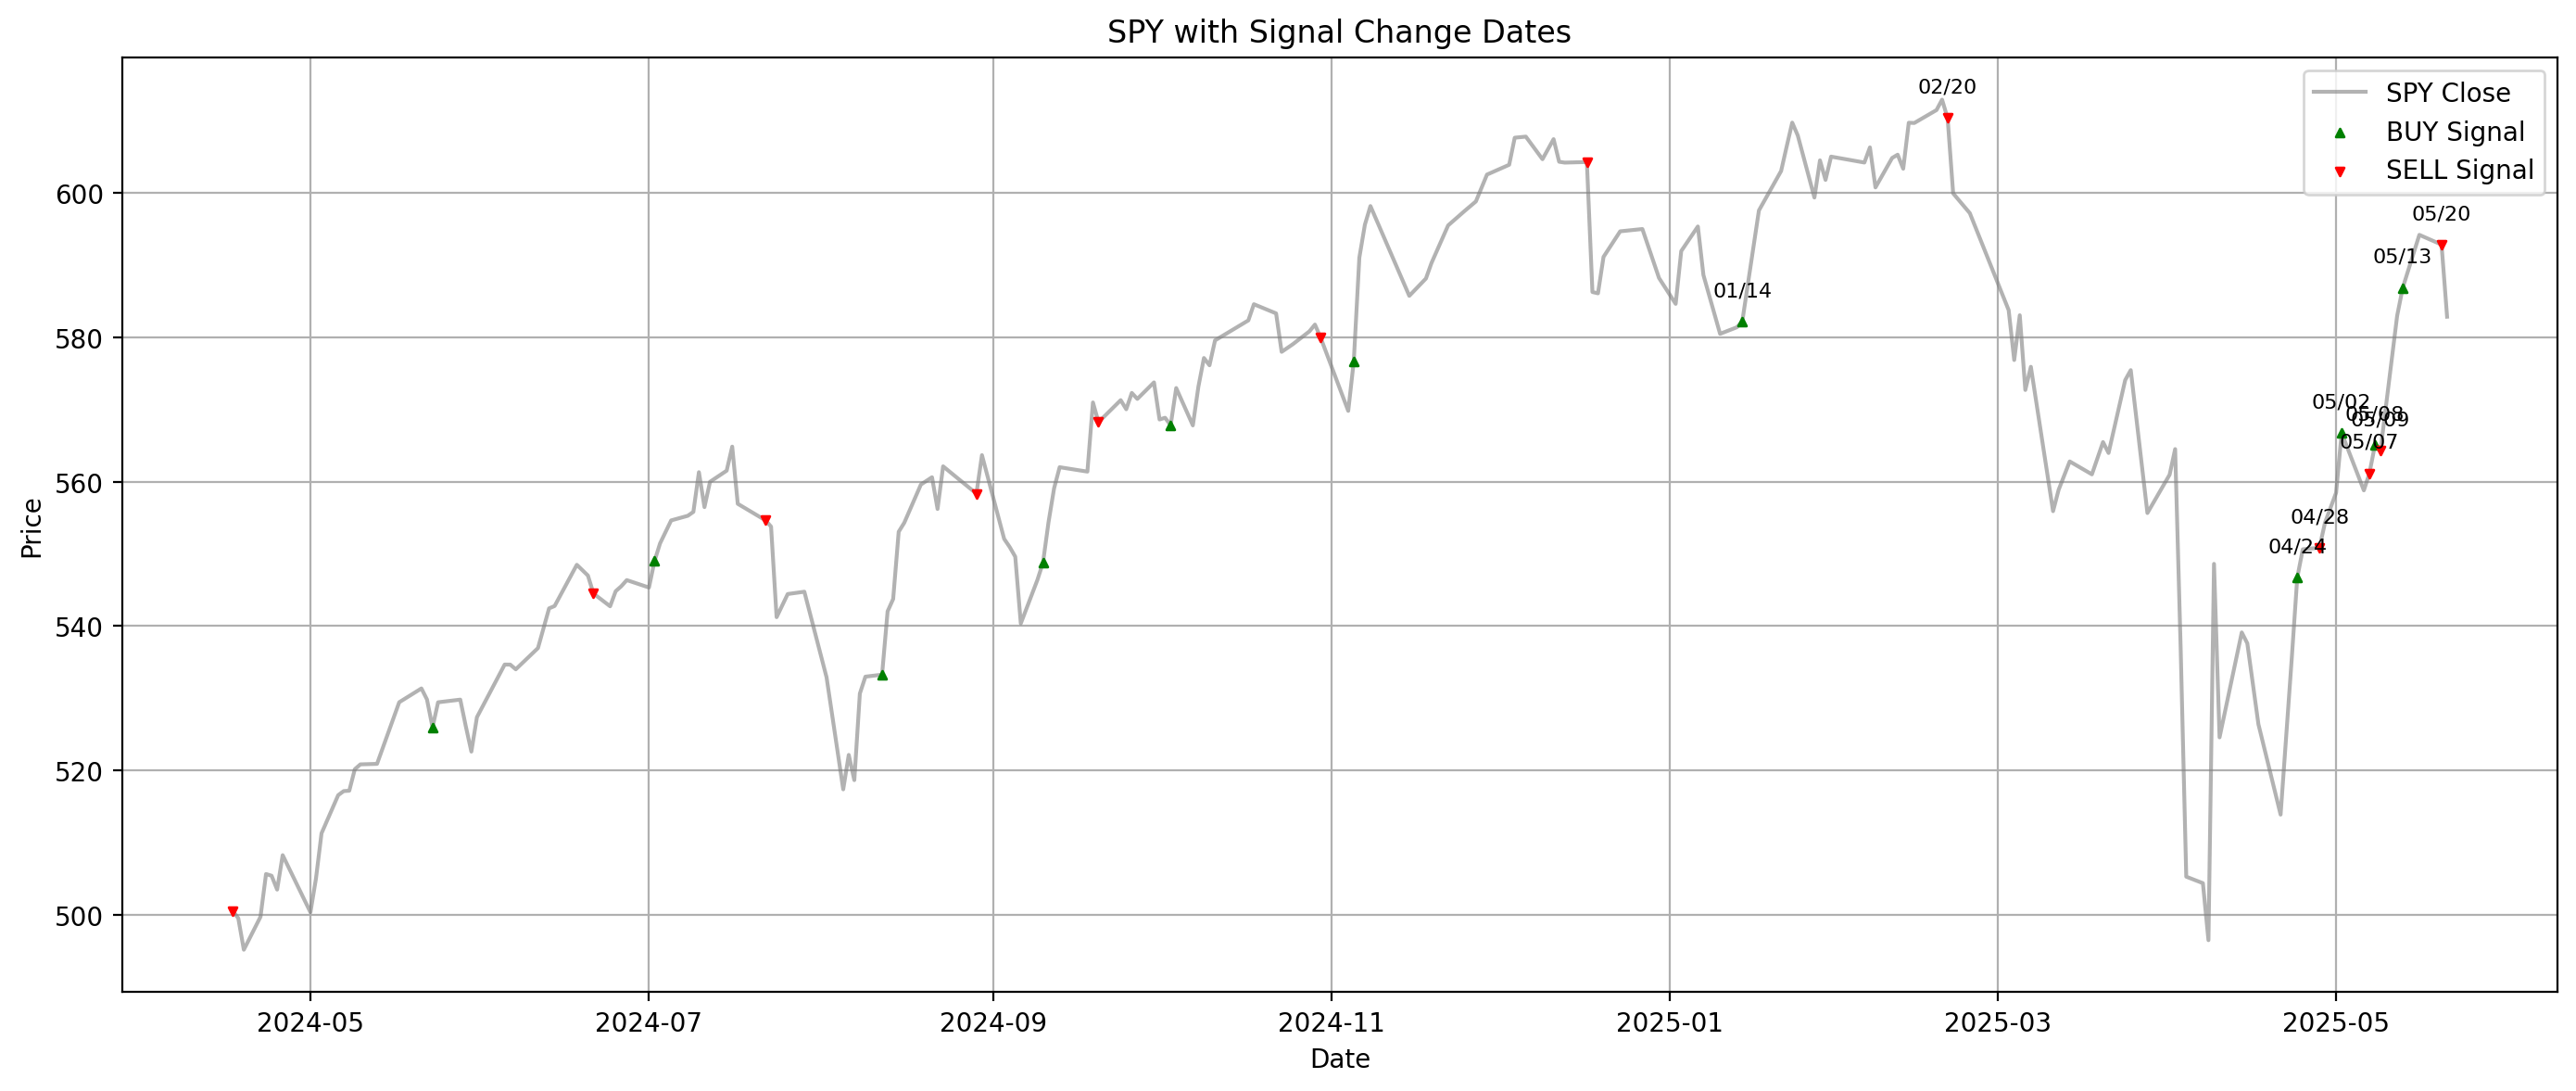

In [ ]:
import matplotlib.pyplot as plt

# Base series to plot — SPY price (already indexed by date)
price_series = plot_df['Close']
dates = plot_df.index  # use the datetime index

# Get only rows where signal changed
signal_change_df = plot_df[plot_df['Signal_Label'] != plot_df['Signal_Label'].shift(1)].copy()

# Split into BUY and SELL signal points
buy_signals = signal_change_df[signal_change_df['Signal_Label'] == 'BUY']
sell_signals = signal_change_df[signal_change_df['Signal_Label'] == 'SELL']

# Plot price chart
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, price_series, label='SPY Close', color='gray', alpha=0.6)

# Add BUY markers
ax.scatter(buy_signals.index, price_series.loc[buy_signals.index],
           marker='^', color='green', label='BUY Signal', s=10, zorder=3)

# Add SELL markers
ax.scatter(sell_signals.index, price_series.loc[sell_signals.index],
           marker='v', color='red', label='SELL Signal', s=10, zorder=3)

# Annotate with short dates
for _, row in signal_change_df.tail(10).iterrows():
    ax.annotate(row['Date'], (row.name, price_series.loc[row.name]),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

# Labels & formatting
ax.set_title("SPY with Signal Change Dates")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-20-a7f048d2d493>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df_filtered['strategy_total_return'] = (plot_df_filtered['strategy_cum'] - 1) * 100
<ipython-input-20-a7f048d2d493>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df_filtered['buy_hold_total_return'] = (plot_df_filtered['buy_hold_cum'] - 1) * 100


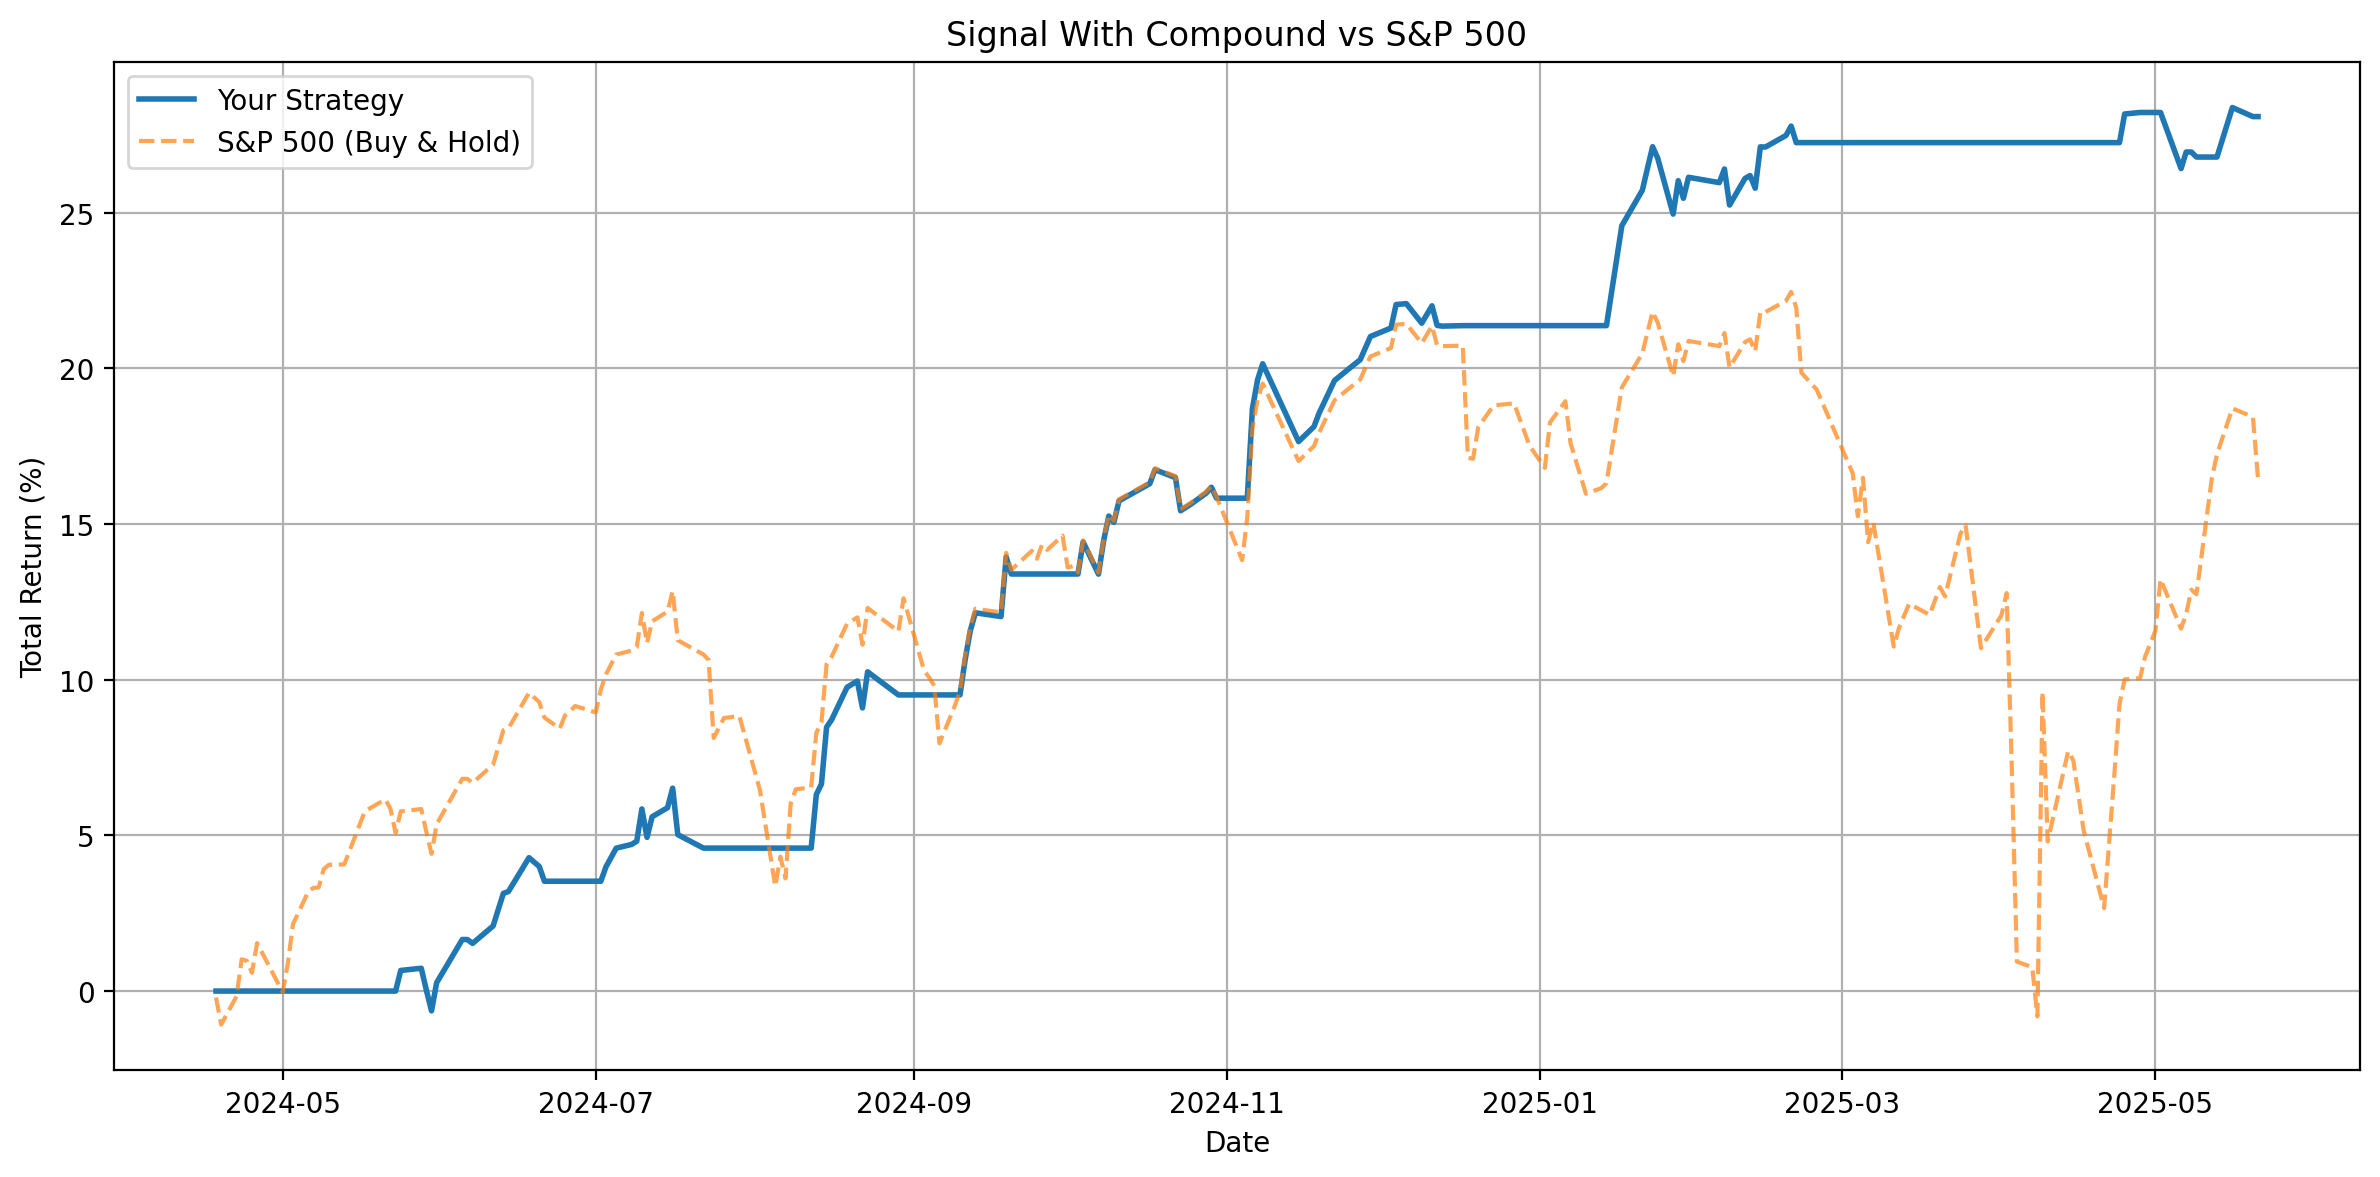

In [ ]:
import matplotlib.pyplot as plt

# Drop NaNs just in case
plot_df_filtered = plot_df.dropna(subset=['strategy_cum', 'buy_hold_cum'])

# Convert cumulative returns to total return % (starting from 0%)
plot_df_filtered['strategy_total_return'] = (plot_df_filtered['strategy_cum'] - 1) * 100
plot_df_filtered['buy_hold_total_return'] = (plot_df_filtered['buy_hold_cum'] - 1) * 100

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df_filtered.index, plot_df_filtered['strategy_total_return'], label='Your Strategy', linewidth=2)
plt.plot(plot_df_filtered.index, plot_df_filtered['buy_hold_total_return'], label='S&P 500 (Buy & Hold)', linestyle='--', alpha=0.7)

plt.title("Signal With Compound vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Total Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()